In [11]:
import efficient_rerank as er
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
import pickle
import pandas as pd
import os

In [25]:
# load in model, for french
del model
model = er.XLMCometEmbeds(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/divlat19.pt"))
model.eval()
torch.cuda.memory_allocated(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2224514048

In [34]:
old = pd.DataFrame(res)

In [35]:
base = "frtest_reversed/"
def test_graph_ind(ind, basedir):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    if g['input'] in old['src']:
        return None, None, None
    try:
        return g['input'], g['ref'], er.run_pipeline(g, model)
    except:
        return None, None, None
    
def get_all_preds(basedir):
    l = len(os.listdir(basedir))
    res = []
    for i in range(l):
        i, r, p = test_graph_ind(i, basedir)
        res.append({
            'src':i,
            'hyp':p,
            'ref':r
        })
        print(i)
    res = pd.DataFrame(res)
    res.to_csv("latfound"+basedir[:-4]+".csv")
    return res

In [ ]:
frpreds = get_all_preds("frtest_reversed/")

In [ ]:
depreds = get_all_preds("detest_reversed/")

In [28]:
basedir = "frtest_reversed/"
l = len(os.listdir(basedir))
res = []

In [ ]:
for i in range(l):
    i, r, p = test_graph_ind(i, basedir)
    if i==None:
        continue
    res.append({
        'src':i,
        'hyp':p,
        'ref':r
    })
    print(i)
resdf = pd.DataFrame(res)
frpreds = resdf
resdf.to_csv("frenchlatpreds")

In [37]:
del model
model = er.XLMCometEmbeds(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/germanlat0.pt"))
model.eval()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMCometEmbeds(
  (xlmroberta): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [ ]:
basedir = "detest_reversed/"
l = len(os.listdir(basedir))
res = []
for i in range(l):
    i, r, p = test_graph_ind(i, basedir)
    res.append({
        'src':i,
        'hyp':p,
        'ref':r
    })
    print(i)
resdf = pd.DataFrame(res)
depreds = resdf.to_csv("germanlatpreds")

In [40]:
resdf

,src,hyp,ref
0,"By the time Mao Zedong died, in 1976, the rura...","<s> By the time Mao Zedong died, in 1976, the ...","Als Mao Tse-Tung im Jahr 1976 starb, lag die W..."
1,(If the TTIP was opened to other economies – s...,<s> (If the TTIP was opened to other economies...,(Würde TTIP für andere Volkswirtschaften – wie...
2,"On the other hand, China remains trapped by a ...","<s> On the other hand, China remains trapped b...",Auf der anderen Seite bleibt China seiner Verg...
3,"(Simonyi wrote the Microsoft Word program, and...","<s> (Simonyi wrote the Microsoft Word program,...",(Simonyi entwickelte das Programm Microsoft Wo...
4,Everyone agrees that Iran has the right to do ...,<s> Everyone agrees that Iran has the right to...,"Alle sind sich einig, dass dem Iran das Recht ..."
...,...,...,...
1072,But this does not mean that we should just cut...,<s> But this does not mean that we should just...,"Aber das heißt nicht, dass wir einfach auf all..."
1073,It might seem from these numbers that Europe h...,<s> It might seem from these numbers that Euro...,"Aus diesen Zahlen könnte man ableiten, dass di..."
1074,"In other words, the structures that companies ...","<s> In other words, the structures that compan...","Anders ausgedrückt: Die Strukturen, die Untern..."
1075,"On October 24, you can stand up against this i...","<s> On October 24, you can stand up against th...","Am 24. Oktober besteht die Möglichkeit, gegen ..."


In [74]:
frpreds = pd.read_csv("frenchlatpreds")

In [65]:
depreds.loc[0]['hyp']

'<s> By the time Mao Zedong died, in 1976, the rural economy was a shambles.</s><s> de_DE Bei der Todestagszeit Mao Zedongs, im Jahr 1976, war die ländliche Wirtschaft in einem Schlamm.'

In [75]:
def get_act_hyps(hyplist, cutoff):
    res = []
    for h in hyplist:
        cind = h[3:].index(cutoff)+len(cutoff)+3
        res.append(h[cind:])
    return res

In [76]:
frpreds['ahyp'] = get_act_hyps(frpreds['hyp'], "<s>")

In [77]:
frpreds

,Unnamed: 0,src,hyp,ref,ahyp
0,0,"Après tout, en tant que journaliste d'investig...","<s> Après tout, en tant que journaliste d'inve...","After all, as a campaigning investigative jour...","After all, as an investigative reporter in th..."
1,1,Au fur et à mesure que l’Iran a cherché à éten...,<s> Au fur et à mesure que l’Iran a cherché à ...,As Iran seeks to assert its influence and inte...,As Iran sought to extend its influence and ad...
2,2,Une autre variable réside dans la question de ...,<s> Une autre variable réside dans la question...,Another variable is how much easier monetary p...,The other variable is the extent to which oth...
3,3,Il nous faut négocier un nouvel accord de part...,<s> Il nous faut négocier un nouvel accord de ...,A new Partnership and Cooperation Agreement (P...,We need to negotiate a new partnership and co...
4,4,Et lorsqu’une région du monde conçoit une meil...,<s> Et lorsqu’une région du monde conçoit une ...,And as one region in one part of the world des...,And when a region of the world devises better...
...,...,...,...,...,...
839,839,"Au moment même de lire ces lignes, des personn...","<s> Au moment même de lire ces lignes, des per...","As you read this, perfectly ordinary people so...","At the very time of reading these lines, perf..."
840,840,C’est ainsi que les médias traditionnels se so...,<s> C’est ainsi que les médias traditionnels s...,"As a result, mainstream media are being margin...","As a result, the traditional media have progr..."
841,841,Un troisième impératif est de construire un mo...,<s> Un troisième impératif est de construire u...,A third imperative is building a safer and mor...,A third imperative is the building of a safer...
842,842,Une approche « portefeuille » du changement cl...,<s> Une approche « portefeuille » du changemen...,A “Portfolio” Approach to Climate Change,"A ""portfolio "" approach to global climate cha..."


In [78]:
def get_comet_scores(hyps, srcs, refs):
    cometqe_input = [{"src": src, "mt": mt, "ref":ref} for src, mt, ref in zip(srcs, hyps, refs)]
    # sentence-level and corpus-level COMET
    outputs = comet.predict(
        cometqe_input, batch_size=32, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

In [79]:
cometqe_dir = "./cometqemodel"
# can alternatively use wmt21-comet-qe-mqm
cometqe_model = "wmt20-comet-qe-da"
cometmodel = "wmt20-comet-da"
batch_size = 64
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [80]:
from comet import download_model, load_from_checkpoint


In [ ]:
comet_path = download_model(cometmodel, "./cometmodel")
comet = load_from_checkpoint(comet_path)
comet.to(device)

In [56]:
del model

In [ ]:
scos = get_comet_scores(frpreds['ahyp'], frpreds['src'], frpreds['ref'])

In [82]:
frpreds['scos'] = scos[0]

In [83]:
frpreds.to_csv("frenchlatpreds")

In [94]:
frpreds[frpreds['scos']<0].loc[25]['ref']

'Already nearly everybody in the North Atlantic region has enough food to avoid hunger, enough clothing to stay warm, enough shelter to remain dry. And yet we want more, feel resentful when we do not get it, and are self-aware enough to know that luxuries turn into conveniences, and then into necessities – and that we are very good at inventing new luxuries after which to strive. '

In [97]:
sum(depreds['scos'])/1077

0.03813996849133665

In [100]:
import matplotlib.pyplot as plt

(array([  3.,   8.,  28.,  12.,  14.,  14.,  64., 110., 374., 217.]),
 array([-1.84165907, -1.55159155, -1.26152403, -0.97145652, -0.681389  ,
        -0.39132148, -0.10125396,  0.18881356,  0.47888107,  0.76894859,
         1.05901611]),
 <BarContainer object of 10 artists>)

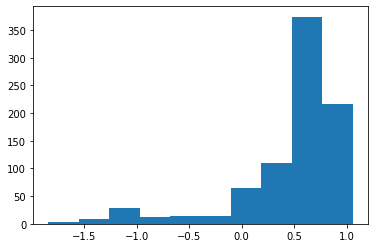

In [101]:
plt.hist(frpreds['scos'])